In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('local_file.csv')

In [3]:
# Assuming df is your DataFrame
# One-hot encode categorical columns and drop the first category to avoid multicollinearity
df = pd.get_dummies(df, columns=['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime'], drop_first=True)

# Set EmployeeNumber as the index
df.set_index('EmployeeNumber', inplace=True)

# Define features and target
X = df.drop(columns=['Attrition_Yes'])
y = df['Attrition_Yes']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [24]:
df.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Attrition_Yes', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Male', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'Jo

In [25]:
df['YearsWithCurrManager'].value_counts()

YearsWithCurrManager
2     344
0     263
7     216
3     142
8     107
4      98
1      76
9      64
5      31
6      29
10     27
11     22
12     18
13     14
17      7
15      5
14      5
16      2
Name: count, dtype: int64

In [6]:
# Initialize and train XGBoost classifier
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

       False       0.87      0.98      0.92       247
        True       0.71      0.26      0.38        47

    accuracy                           0.86       294
   macro avg       0.79      0.62      0.65       294
weighted avg       0.85      0.86      0.84       294

ROC AUC: 0.7413213885778276


In [10]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the XGBoost classifier with adjusted class weights
scale_pos_weight = (len(y_train_resampled) - sum(y_train_resampled)) / sum(y_train_resampled)
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

       False       0.89      0.94      0.92       247
        True       0.56      0.38      0.46        47

    accuracy                           0.85       294
   macro avg       0.73      0.66      0.69       294
weighted avg       0.84      0.85      0.84       294

ROC AUC: 0.7602722026014299


In [15]:
import xgboost as xgb
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

# Apply SMOTETomek to the training data
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# Initialize the XGBoost classifier with adjusted class weights
scale_pos_weight = (len(y_train_resampled) - sum(y_train_resampled)) / sum(y_train_resampled)
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, use_label_encoder=False)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [4, 5, 6],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0.05, 0.1],
    'min_child_weight': [1, 2]
}

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring='roc_auc', cv=5, n_jobs=-1, n_iter=30, random_state=42)
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best model from random search
best_model = random_search.best_estimator_

# Predict probabilities
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Adjust the threshold to improve F1 score
threshold = 0.35  # Adjust this value to control the trade-off
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_adjusted))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

# Confusion Matrix to see the trade-off
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.90      0.90       247
        True       0.45      0.43      0.44        47

    accuracy                           0.83       294
   macro avg       0.67      0.66      0.67       294
weighted avg       0.82      0.83      0.82       294

ROC AUC: 0.7880093031268843
Confusion Matrix:
[[223  24]
 [ 27  20]]


c:\Users\jer93\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [23]:
best_model.save_model("xgboost_model.json")

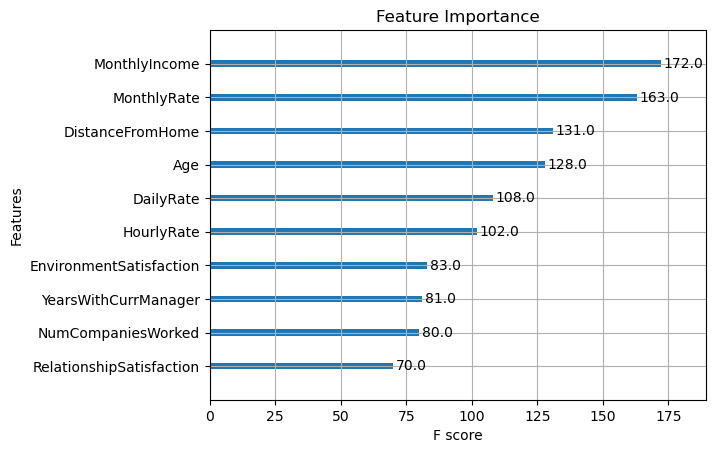

In [16]:
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()

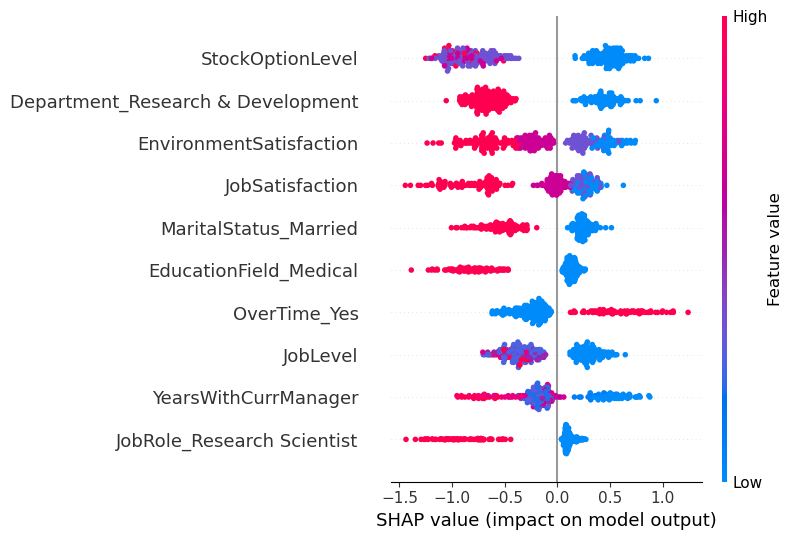

In [22]:
import shap
import matplotlib.pyplot as plt

# Compute SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Get the top 10 features
top_10_features = X_test.columns[np.argsort(np.abs(shap_values).mean(0))[-10:]]

# Filter the SHAP values and the test data for the top 10 features
shap_values_top_10 = shap_values[:, np.argsort(np.abs(shap_values).mean(0))[-10:]]
X_test_top_10 = X_test[top_10_features]

# Create SHAP summary plot for the top 10 features
shap.summary_plot(shap_values_top_10, X_test_top_10, plot_type="dot", color=plt.get_cmap("coolwarm"))
plt.show()

